<a href="https://colab.research.google.com/github/emerson-matos/tcc-notebooks/blob/main/sentimentos/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
!nvidia-smi

Sat Sep 16 05:33:36 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070 Ti     Off | 00000000:08:00.0  On |                  N/A |
|  0%   39C    P0              43W / 285W |   1041MiB / 12282MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

In [3]:
date = '2023-09-01'
filename = 'analisar.csv'
dados = pd.read_csv(f"/content/gdrive/MyDrive/tcc/exploratoria/{date}-{filename}")

dados.head()[['text', 'source', 'data_avaliacao']]

,text,source,data_avaliacao
0,"Lugar fantástico, recomendo super.",hotel-marsol-beach-resort,2023-07-06
1,Tudo perfeito,hotel-marsol-beach-resort,2023-07-06
2,excelente!,hotel-marsol-beach-resort,2023-07-06
3,Belo lugar.,hotel-marsol-beach-resort,2023-07-06
4,Ótimo local,hotel-marsol-beach-resort,2023-07-06


In [4]:
treinado = pd.read_csv(f"/content/gdrive/MyDrive/tcc/testando-classificacao.csv")

treinado.head()[['text', 'source', 'data_avaliacao']]

,text,source,data_avaliacao
0,"Lugar fantástico, recomendo super.",analisar,2023-07-06
1,Tudo perfeito,analisar,2023-07-06
2,excelente!,analisar,2023-07-06
3,Belo lugar.,analisar,2023-07-06
4,Ótimo local,analisar,2023-07-06


In [5]:
dados.describe()

,rating,likes,mes_avaliacao,ano_avaliacao
count,49219.000000,49219.000000,49219.000000,49219.000000
mean,4.604787,0.166623,6.790650,2020.699181
std,0.895289,0.731727,1.524495,1.746374
min,1.000000,0.000000,1.000000,2018.000000
25%,5.000000,0.000000,7.000000,2019.000000
50%,5.000000,0.000000,7.000000,2021.000000
75%,5.000000,0.000000,7.000000,2022.000000
max,5.000000,25.000000,12.000000,2023.000000


# 08

In [6]:
!pip install transformers[sentencepiece] datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 85.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 116.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 24.8 MB/s eta 0:00:00


## bert pre treinado

In [59]:
sentences = [
  'Foi muito bom, exceto o primeiro atendimento na recepção na chegada, fizemos o chek-in e não nos informaram onde ficaria o nosso chalé, tivemos que ficar perguntando a alguns funcionários, fora isso tudo de bom.',
  'Lindo d mais',
  'Muito bom. Vale o valor pago',
  'Tudo perfeito',
  'Drinks muito bom',
  'Incrível',
  'Foi ótimo dias maravilhosos...',
  'Passagem incrível.  Boa comida.  Piscinas amplas com águas mornas.',
  'Alimentação péssima! Do mais tudo ok!',
  'Muito sofisticado',
  'Otima',
  'Lugar fantástico, recomendo super.',
  'Estou deslumbrado com a beleza ,ao entorno do hotel ,quarto amplo e confortável ,a piscina espetacular ,foi uma experiência incrível!!!'
]

In [8]:
import torch
from transformers import AutoTokenizer  # Or BertTokenizer
from transformers import AutoModelForSequenceClassification  # Or BertForPreTraining for loading pretraining heads
from transformers import pipeline


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

teste = dados.copy()

teste.head(5)

,retrieval_date,rating,relative_date,likes,user_is_local_guide,text,source,user_reviews,data_avaliacao,mes_avaliacao,ano_avaliacao,mes_ano_avaliacao,com_texto,nao_vazio,traduzido,depois_2017,analisar
0,2023-07-07 00:33:49.096786,5.0,10 horas atrás,0,False,"Lugar fantástico, recomendo super.",hotel-marsol-beach-resort,9,2023-07-06,7,2023,2023-07,True,True,False,True,True
1,2023-07-07 00:33:49.185915,5.0,10 horas atrás,0,True,Tudo perfeito,hotel-marsol-beach-resort,36,2023-07-06,7,2023,2023-07,True,True,False,True,True
2,2023-07-07 00:33:50.064473,5.0,11 horas atrás,0,True,excelente!,hotel-marsol-beach-resort,52,2023-07-06,7,2023,2023-07,True,True,False,True,True
3,2023-07-07 00:33:50.080896,5.0,11 horas atrás,0,True,Belo lugar.,hotel-marsol-beach-resort,41,2023-07-06,7,2023,2023-07,True,True,False,True,True
4,2023-07-07 00:33:50.109826,5.0,11 horas atrás,0,False,Ótimo local,hotel-marsol-beach-resort,7,2023-07-06,7,2023,2023-07,True,True,False,True,True


In [9]:
PRE_TRAINED_MODEL_NAME_1 = 'philschmid/distilbert-base-multilingual-cased-sentiment'

tokenizer1 = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME_1, do_lower_case=False)
model1 = AutoModelForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME_1).to(device)
classifier1 = pipeline('sentiment-analysis',
                      model=model1,
                      tokenizer=tokenizer1,
                      max_length=512,
                      truncation=True,
                      pad_to_max_length=True,
                      device=device,
                      framework="pt",
                      batch_size=16,
)

In [56]:
classifier1(sentences)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


[{'label': 'negative', 'score': 0.9226691722869873},
 {'label': 'neutral', 'score': 0.4194216728210449},
 {'label': 'negative', 'score': 0.8745064735412598},
 {'label': 'positive', 'score': 0.9755363464355469},
 {'label': 'negative', 'score': 0.7377951145172119},
 {'label': 'negative', 'score': 0.5013454556465149},
 {'label': 'negative', 'score': 0.4844314754009247},
 {'label': 'neutral', 'score': 0.5337896943092346},
 {'label': 'negative', 'score': 0.9250680804252625},
 {'label': 'neutral', 'score': 0.42814022302627563},
 {'label': 'positive', 'score': 0.8648582696914673},
 {'label': 'positive', 'score': 0.9849022030830383},
 {'label': 'positive', 'score': 0.9673092365264893}]

In [57]:
PRE_TRAINED_MODEL_NAME_2 = 'lxyuan/distilbert-base-multilingual-cased-sentiments-student'

tokenizer2 = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME_2, do_lower_case=False)
model2 = AutoModelForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME_2).to(device)
classifier2 = pipeline('sentiment-analysis',
                      model=model2,
                      tokenizer=tokenizer2,
                      max_length=512,
                      truncation=True,
                      pad_to_max_length=True,
                      device=device,
                      framework="pt",
                      batch_size=16,
)

In [60]:
classifier2(sentences)

[{'label': 'negative', 'score': 0.5495229959487915},
 {'label': 'positive', 'score': 0.5910864472389221},
 {'label': 'positive', 'score': 0.8239201903343201},
 {'label': 'negative', 'score': 0.6602097749710083},
 {'label': 'positive', 'score': 0.5783613920211792},
 {'label': 'positive', 'score': 0.533176600933075},
 {'label': 'positive', 'score': 0.9308533072471619},
 {'label': 'positive', 'score': 0.7248801589012146},
 {'label': 'positive', 'score': 0.7259961366653442},
 {'label': 'negative', 'score': 0.5079984664916992},
 {'label': 'positive', 'score': 0.5399190783500671},
 {'label': 'positive', 'score': 0.9592684507369995},
 {'label': 'negative', 'score': 0.7474359273910522}]

In [14]:
PRE_TRAINED_MODEL_NAME_3 = 'citizenlab/twitter-xlm-roberta-base-sentiment-finetunned'

tokenizer3 = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME_3, do_lower_case=False)
model3 = AutoModelForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME_3).to(device)
classifier3 = pipeline('sentiment-analysis',
                      model=model3,
                      tokenizer=tokenizer3,
                      max_length=512,
                      truncation=True,
                      pad_to_max_length=True,
                      device=device,
                      framework="pt",
                      batch_size=16,
)

In [15]:
classifier3(sentences)

[{'label': 'Positive', 'score': 0.9781147837638855},
 {'label': 'Positive', 'score': 0.9915336966514587},
 {'label': 'Positive', 'score': 0.9922174215316772},
 {'label': 'Positive', 'score': 0.9926760792732239},
 {'label': 'Positive', 'score': 0.9896873831748962},
 {'label': 'Positive', 'score': 0.9074751734733582},
 {'label': 'Positive', 'score': 0.9909008741378784},
 {'label': 'Positive', 'score': 0.9921296238899231},
 {'label': 'Negative', 'score': 0.9787968397140503},
 {'label': 'Negative', 'score': 0.9137847423553467},
 {'label': 'Positive', 'score': 0.9924835562705994},
 {'label': 'Positive', 'score': 0.9925462603569031},
 {'label': 'Positive', 'score': 0.99159836769104}]

In [16]:
PRE_TRAINED_MODEL_NAME_4 = 'cardiffnlp/twitter-xlm-roberta-base-sentiment'

tokenizer4 = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME_4, do_lower_case=False)
model4 = AutoModelForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME_4).to(device)
classifier4 = pipeline('sentiment-analysis',
                      model=model4,
                      tokenizer=tokenizer4,
                      max_length=512,
                      truncation=True,
                      pad_to_max_length=True,
                      device=device,
                      framework="pt",
                      batch_size=16,
)

In [17]:
classifier4(sentences)

[{'label': 'positive', 'score': 0.5777750015258789},
 {'label': 'positive', 'score': 0.8819499611854553},
 {'label': 'positive', 'score': 0.9002392888069153},
 {'label': 'positive', 'score': 0.8959977030754089},
 {'label': 'positive', 'score': 0.8850589990615845},
 {'label': 'positive', 'score': 0.695933997631073},
 {'label': 'positive', 'score': 0.9281375408172607},
 {'label': 'positive', 'score': 0.9304505586624146},
 {'label': 'negative', 'score': 0.9328173398971558},
 {'label': 'negative', 'score': 0.4048030972480774},
 {'label': 'positive', 'score': 0.6601681113243103},
 {'label': 'positive', 'score': 0.9392898678779602},
 {'label': 'positive', 'score': 0.9188212156295776}]

In [18]:
PRE_TRAINED_MODEL_NAME_5 = 'ramonmedeiro1/bertimbau-products-reviews-pt-br'

tokenizer5 = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME_5, do_lower_case=False)
model5 = AutoModelForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME_5).to(device)
classifier5 = pipeline('sentiment-analysis',
                      model=model5,
                      tokenizer=tokenizer5,
                      max_length=512,
                      truncation=True,
                      pad_to_max_length=True,
                      device=device,
                      framework="pt",
                      batch_size=16,
)

In [19]:
classifier5(sentences)

[{'label': 'Positivo', 'score': 0.5946270823478699},
 {'label': 'Muito Positivo', 'score': 0.9520754218101501},
 {'label': 'Positivo', 'score': 0.5735266208648682},
 {'label': 'Muito Positivo', 'score': 0.8601934313774109},
 {'label': 'Positivo', 'score': 0.5460475087165833},
 {'label': 'Muito Positivo', 'score': 0.9668323993682861},
 {'label': 'Muito Positivo', 'score': 0.8012335896492004},
 {'label': 'Muito Positivo', 'score': 0.9259946942329407},
 {'label': 'Negativo', 'score': 0.6605251431465149},
 {'label': 'Muito Positivo', 'score': 0.8711700439453125},
 {'label': 'Muito Positivo', 'score': 0.4971369802951813},
 {'label': 'Muito Positivo', 'score': 0.936265766620636},
 {'label': 'Muito Positivo', 'score': 0.9635603427886963}]

In [20]:
treinado.head()

,retrieval_date,rating,relative_date,likes,user_is_local_guide,text,source,user_reviews,data_avaliacao,mes_avaliacao,ano_avaliacao,mes_ano_avaliacao,com_texto,nao_vazio,traduzido,depois_2017,analisar,text_truncado,sentiment_bert
0,2023-07-07 00:33:49.096786,5.0,10 horas atrás,0,False,"Lugar fantástico, recomendo super.",analisar,9,2023-07-06,7,2023,2023-07,True,True,False,True,True,"Lugar fantástico, recomendo super.",positive
1,2023-07-07 00:33:49.185915,5.0,10 horas atrás,0,True,Tudo perfeito,analisar,36,2023-07-06,7,2023,2023-07,True,True,False,True,True,Tudo perfeito,negative
2,2023-07-07 00:33:50.064473,5.0,11 horas atrás,0,True,excelente!,analisar,52,2023-07-06,7,2023,2023-07,True,True,False,True,True,excelente!,positive
3,2023-07-07 00:33:50.080896,5.0,11 horas atrás,0,True,Belo lugar.,analisar,41,2023-07-06,7,2023,2023-07,True,True,False,True,True,Belo lugar.,positive
4,2023-07-07 00:33:50.109826,5.0,11 horas atrás,0,False,Ótimo local,analisar,7,2023-07-06,7,2023,2023-07,True,True,False,True,True,Ótimo local,positive


In [ ]:
from datasets import Dataset
dataset = Dataset.from_pandas(teste)

In [ ]:
dataset = dataset.map(lambda x: {"sentiment_bert_1": classifier1(x['text']),
                                 "sentiment_bert_2": classifier2(x['text']),
                                 "sentiment_bert_3": classifier3(x['text']),
                                 "sentiment_bert_4": classifier3(x['text']),
                                 "sentiment_bert_5": classifier3(x['text'])}, batched=True)

In [ ]:
dataset[0]

In [ ]:
teste = dataset.to_pandas()

teste.head(5)

In [ ]:
def mySorter(e):
  return e['score']

cols = ['sentiment_bert_1', 'sentiment_bert_2', 'sentiment_bert_3', 'sentiment_bert_4', 'sentiment_bert_5']
teste['sentiment_bert'] = teste[cols].apply(lambda row: row.values.tolist(), axis=1)

In [ ]:
teste['sentiment_bert'] = teste['sentiment_bert'].apply(lambda x: sorted(x, key=mySorter, reverse=True))

In [ ]:
teste[['sentiment_bert']].sample(n=10)

In [ ]:
def f7(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]
teste['sentiment_label'] = teste['sentiment_bert'].apply(lambda x: f7(list(map(lambda y: y['label'].lower(), x))))
teste['sentiment_score'] = teste['sentiment_bert'].apply(lambda x: set(map(lambda y: y['score'], x)))

In [29]:
teste[['ano_avaliacao', 'source', 'text', 'sentiment_bert', 'sentiment_label', 'sentiment_score']].sample(n = 30)

SyntaxError: ignored

In [ ]:
teste[teste.text == 'Lindo d mais']

In [ ]:
# teste.to_csv('/content/gdrive/MyDrive/tcc/bert/analise_sentimento.csv')

In [22]:
teste = pd.read_csv('/content/gdrive/MyDrive/tcc/bert/analise_sentimento.csv')

In [ ]:
import seaborn as sns

sns.relplot(x='ano_avaliacao', y='sentiment_score', kind="line", hue='sentiment_label', data=teste)

In [24]:
sns.relplot(x='ano_avaliacao', y='sentiment_score_2', kind="line", hue='sentiment_label_2', data=teste)

ValueError: ignored

<Axes: xlabel='ano_avaliacao', ylabel='count'>

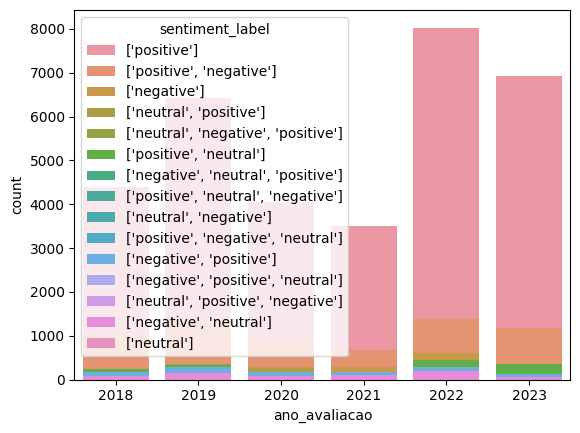

In [26]:
sns.countplot(x='ano_avaliacao',
              hue='sentiment_label',
              data=teste,
              dodge=False)

In [ ]:
sns.countplot(x='ano_avaliacao',
              hue='sentiment_label_2',
              data=teste)

In [27]:
sns.relplot(x='ano_avaliacao', col_wrap=3, col="source", y='sentiment_score', hue='sentiment_label', data=teste, kind='line')

KeyboardInterrupt: ignored

Error in callback <function _draw_all_if_interactive at 0x7f577bad2cb0> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f577bad1f30> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
teste[(teste.sentiment_label != teste.sentiment_label_2)][['text','sentiment_label', 'sentiment_score']]

In [ ]:
sns.relplot(x='ano_avaliacao', y='sentiment_score_2', kind="line", hue='sentiment_label_2', data=teste[(teste.sentiment_label != teste.sentiment_label_2)], palette='Set2')
sns.relplot(x='ano_avaliacao', y='sentiment_score', kind="line", hue='sentiment_label', data=teste[(teste.sentiment_label != teste.sentiment_label_2)], palette='Set2')

In [ ]:
sns.scatterplot(data=teste[(teste.sentiment_label != teste.sentiment_label_2) & (abs(teste.sentiment_score - teste.sentiment_score_2) > 0.00)], x="sentiment_score", y="sentiment_score_2")

In [30]:
teste[(teste.sentiment_label != teste.sentiment_label_2) & (abs(teste.sentiment_score - teste.sentiment_score_2) > 0.00)].sample()

AttributeError: ignored

In [49]:
import ast

ast.literal_eval(teste['sentiment_label'][0])

['positive']

In [61]:
teste[teste['sentiment_label'].apply(lambda x: len(ast.literal_eval(x)) == 1)][['sentiment_label', 'text', 'sentiment_bert_1', 'sentiment_bert_2', 'sentiment_bert_3', 'sentiment_bert_4','sentiment_bert_5']]

,sentiment_label,text,sentiment_bert_1,sentiment_bert_2,sentiment_bert_3,sentiment_bert_4,sentiment_bert_5
0,['positive'],"Lugar fantástico, recomendo super.","{'label': 'positive', 'score': 0.9849022030830...","{'label': 'positive', 'score': 0.9592684507369...","{'label': 'Positive', 'score': 0.9925462603569...","{'label': 'Positive', 'score': 0.9925462603569...","{'label': 'Positive', 'score': 0.9925462603569..."
2,['positive'],excelente!,"{'label': 'positive', 'score': 0.9857670068740...","{'label': 'positive', 'score': 0.9891675710678...","{'label': 'Positive', 'score': 0.9923394918441...","{'label': 'Positive', 'score': 0.9923394918441...","{'label': 'Positive', 'score': 0.9923394918441..."
3,['positive'],Belo lugar.,"{'label': 'positive', 'score': 0.8551892638206...","{'label': 'positive', 'score': 0.781340479850769}","{'label': 'Positive', 'score': 0.9930474162101...","{'label': 'Positive', 'score': 0.9930474162101...","{'label': 'Positive', 'score': 0.9930474162101..."
4,['positive'],Ótimo local,"{'label': 'positive', 'score': 0.8495931029319...","{'label': 'positive', 'score': 0.5628671050071...","{'label': 'Positive', 'score': 0.9923906922340...","{'label': 'Positive', 'score': 0.9923906922340...","{'label': 'Positive', 'score': 0.9923906922340..."
5,['positive'],excelente local otima vista e hospitalidade pe...,"{'label': 'positive', 'score': 0.9734945893287...","{'label': 'positive', 'score': 0.9737055897712...","{'label': 'Positive', 'score': 0.988045871257782}","{'label': 'Positive', 'score': 0.988045871257782}","{'label': 'Positive', 'score': 0.988045871257782}"
...,...,...,...,...,...,...,...
49213,['positive'],Simplesmente amei,"{'label': 'positive', 'score': 0.727571427822113}","{'label': 'positive', 'score': 0.608471155166626}","{'label': 'Positive', 'score': 0.9922024011611...","{'label': 'Positive', 'score': 0.9922024011611...","{'label': 'Positive', 'score': 0.9922024011611..."
49215,['positive'],Um sonho,"{'label': 'positive', 'score': 0.5642338991165...","{'label': 'positive', 'score': 0.5150464177131...","{'label': 'Positive', 'score': 0.7321606874465...","{'label': 'Positive', 'score': 0.7321606874465...","{'label': 'Positive', 'score': 0.7321606874465..."
49216,['positive'],Excelente Resort,"{'label': 'positive', 'score': 0.987581729888916}","{'label': 'positive', 'score': 0.9462223052978...","{'label': 'Positive', 'score': 0.9921082854270...","{'label': 'Positive', 'score': 0.9921082854270...","{'label': 'Positive', 'score': 0.9921082854270..."
49217,['positive'],Lugar lindo! Ótimo para descansar.,"{'label': 'positive', 'score': 0.9002830386161...","{'label': 'positive', 'score': 0.6816404461860...","{'label': 'Positive', 'score': 0.9932357668876...","{'label': 'Positive', 'score': 0.9932357668876...","{'label': 'Positive', 'score': 0.9932357668876..."


In [67]:
teste[teste['sentiment_label'].apply(lambda x: len(ast.literal_eval(x)) == 2)][['sentiment_label', 'text', 'sentiment_bert_1', 'sentiment_bert_2', 'sentiment_bert_3', 'sentiment_bert_4','sentiment_bert_5']]

,sentiment_label,text,sentiment_bert_1,sentiment_bert_2,sentiment_bert_3,sentiment_bert_4,sentiment_bert_5
1,"['positive', 'negative']",Tudo perfeito,"{'label': 'positive', 'score': 0.9701986312866...","{'label': 'negative', 'score': 0.6602097153663...","{'label': 'Positive', 'score': 0.9922283291816...","{'label': 'Positive', 'score': 0.9922283291816...","{'label': 'Positive', 'score': 0.9922283291816..."
17,"['neutral', 'positive']","Quadra, piscina, praça e ao lado da praia sem ...","{'label': 'neutral', 'score': 0.5129052996635437}","{'label': 'positive', 'score': 0.5697891712188...","{'label': 'Neutral', 'score': 0.6083300113677979}","{'label': 'Neutral', 'score': 0.6083300113677979}","{'label': 'Neutral', 'score': 0.6083300113677979}"
19,"['positive', 'negative']",É um ótimo hotel para levar a família e curtir...,"{'label': 'positive', 'score': 0.9578593969345...","{'label': 'negative', 'score': 0.5199328660964...","{'label': 'Positive', 'score': 0.9722692966461...","{'label': 'Positive', 'score': 0.9722692966461...","{'label': 'Positive', 'score': 0.9722692966461..."
22,"['neutral', 'positive']",Atendimento e alimentação.,"{'label': 'positive', 'score': 0.8624117374420...","{'label': 'positive', 'score': 0.7141097187995...","{'label': 'Neutral', 'score': 0.9898031949996948}","{'label': 'Neutral', 'score': 0.9898031949996948}","{'label': 'Neutral', 'score': 0.9898031949996948}"
28,"['positive', 'negative']","Aconchegante, bem localizado e com ótimo servi...","{'label': 'negative', 'score': 0.70010906457901}","{'label': 'positive', 'score': 0.7468746900558...","{'label': 'Positive', 'score': 0.9913169145584...","{'label': 'Positive', 'score': 0.9913169145584...","{'label': 'Positive', 'score': 0.9913169145584..."
...,...,...,...,...,...,...,...
49199,"['neutral', 'positive']",Melhorar muito a infraestrutura.,"{'label': 'positive', 'score': 0.818744421005249}","{'label': 'positive', 'score': 0.8409448266029...","{'label': 'Neutral', 'score': 0.9386424422264099}","{'label': 'Neutral', 'score': 0.9386424422264099}","{'label': 'Neutral', 'score': 0.9386424422264099}"
49200,"['positive', 'negative']",Pelo atenção e atendimento em todos os sentido...,"{'label': 'positive', 'score': 0.9378687739372...","{'label': 'negative', 'score': 0.5224962830543...","{'label': 'Positive', 'score': 0.9896613359451...","{'label': 'Positive', 'score': 0.9896613359451...","{'label': 'Positive', 'score': 0.9896613359451..."
49201,"['positive', 'negative']",Tudo de bom,"{'label': 'negative', 'score': 0.6747020483016...","{'label': 'negative', 'score': 0.7172132730484...","{'label': 'Positive', 'score': 0.9868878722190...","{'label': 'Positive', 'score': 0.9868878722190...","{'label': 'Positive', 'score': 0.9868878722190..."
49206,"['neutral', 'positive']",Tudo,"{'label': 'positive', 'score': 0.8212609887123...","{'label': 'positive', 'score': 0.4054795801639...","{'label': 'Neutral', 'score': 0.913355827331543}","{'label': 'Neutral', 'score': 0.913355827331543}","{'label': 'Neutral', 'score': 0.913355827331543}"


In [88]:
teste[teste['sentiment_label'].apply(lambda x: len(ast.literal_eval(x)) > 2)][['sentiment_label', 'rating', 'text', 'sentiment_bert_1', 'sentiment_bert_2', 'sentiment_bert_3', 'sentiment_bert_4','sentiment_bert_5']]

,sentiment_label,rating,text,sentiment_bert_1,sentiment_bert_2,sentiment_bert_3,sentiment_bert_4,sentiment_bert_5
20,"['neutral', 'negative', 'positive']",3.0,"O hotel é limpo, os funcionários muito educado...","{'label': 'neutral', 'score': 0.725369930267334}","{'label': 'positive', 'score': 0.507336437702179}","{'label': 'Negative', 'score': 0.5601344108581...","{'label': 'Negative', 'score': 0.5601344108581...","{'label': 'Negative', 'score': 0.5601344108581..."
39,"['negative', 'neutral', 'positive']",5.0,Sem palavras,"{'label': 'positive', 'score': 0.3510648608207...","{'label': 'neutral', 'score': 0.4789133667945862}","{'label': 'Negative', 'score': 0.7170167565345...","{'label': 'Negative', 'score': 0.7170167565345...","{'label': 'Negative', 'score': 0.7170167565345..."
57,"['positive', 'neutral', 'negative']",5.0,Lugar incrível,"{'label': 'neutral', 'score': 0.510798990726471}","{'label': 'negative', 'score': 0.4616160988807...","{'label': 'Positive', 'score': 0.9919718503952...","{'label': 'Positive', 'score': 0.9919718503952...","{'label': 'Positive', 'score': 0.9919718503952..."
130,"['positive', 'neutral', 'negative']",5.0,Lugar incrível,"{'label': 'neutral', 'score': 0.510798990726471}","{'label': 'negative', 'score': 0.4616160988807...","{'label': 'Positive', 'score': 0.9919718503952...","{'label': 'Positive', 'score': 0.9919718503952...","{'label': 'Positive', 'score': 0.9919718503952..."
132,"['positive', 'negative', 'neutral']",3.0,"Difícil dizer,por que amo praia e é um lugar q...","{'label': 'neutral', 'score': 0.45937931537628...","{'label': 'negative', 'score': 0.4774778187274...","{'label': 'Positive', 'score': 0.9845324158668...","{'label': 'Positive', 'score': 0.9845324158668...","{'label': 'Positive', 'score': 0.9845324158668..."
...,...,...,...,...,...,...,...,...
48937,"['positive', 'negative', 'neutral']",5.0,"Camarim Grande é maravilhoso, sendo que infeli...","{'label': 'neutral', 'score': 0.41920384764671...","{'label': 'positive', 'score': 0.7904974818229...","{'label': 'Negative', 'score': 0.714795708656311}","{'label': 'Negative', 'score': 0.714795708656311}","{'label': 'Negative', 'score': 0.714795708656311}"
48961,"['neutral', 'positive', 'negative']",4.0,Lugar para se deixar as pernas voltadas para o...,"{'label': 'positive', 'score': 0.7103403210639...","{'label': 'negative', 'score': 0.4030974209308...","{'label': 'Neutral', 'score': 0.975810170173645}","{'label': 'Neutral', 'score': 0.975810170173645}","{'label': 'Neutral', 'score': 0.975810170173645}"
49096,"['neutral', 'positive', 'negative']",5.0,Conheci pela primeira vez o pecado da gula. Po...,"{'label': 'positive', 'score': 0.8575298190116...","{'label': 'negative', 'score': 0.6595584154129...","{'label': 'Neutral', 'score': 0.9615657329559326}","{'label': 'Neutral', 'score': 0.9615657329559326}","{'label': 'Neutral', 'score': 0.9615657329559326}"
49140,"['neutral', 'negative', 'positive']",4.0,"Passamos só 4 dias no Salinas, pois era só o q...","{'label': 'negative', 'score': 0.9009762406349...","{'label': 'positive', 'score': 0.5664177536964...","{'label': 'Neutral', 'score': 0.9686949849128723}","{'label': 'Neutral', 'score': 0.9686949849128723}","{'label': 'Neutral', 'score': 0.9686949849128723}"


In [84]:
treinado[treinado.text == 'Sem palavras'][['relative_date', 'likes', 'mes_ano_avaliacao', 'analisar', 'sentiment_bert', 'rating', 'text', 'source']]

,relative_date,likes,user_is_local_guide,mes_ano_avaliacao,analisar,sentiment_bert,rating,text,source
39,3 semanas atrás,0,False,2023-06,True,neutral,5.0,Sem palavras,analisar
7025,2 semanas atrás,0,False,2023-06,True,neutral,5.0,Sem palavras,analisar
14824,4 anos atrás,0,True,2019-07,True,neutral,5.0,Sem palavras,analisar
24048,5 anos atrás,0,True,2018-07,True,neutral,5.0,Sem palavras,analisar
28383,5 anos atrás,0,True,2018-07,True,neutral,5.0,Sem palavras,analisar
39693,4 anos atrás,1,False,2019-07,True,neutral,5.0,Sem palavras,analisar
40325,5 anos atrás,0,False,2018-07,True,neutral,5.0,Sem palavras,analisar


In [86]:
teste[teste.text == 'Sem palavras'][['relative_date', 'likes', 'mes_ano_avaliacao', 'analisar', 'sentiment_bert', 'rating', 'text', 'source']]

,relative_date,likes,mes_ano_avaliacao,analisar,sentiment_bert,rating,text,source
39,3 semanas atrás,0,2023-06,True,"[{'label': 'Negative', 'score': 0.717016756534...",5.0,Sem palavras,hotel-marsol-beach-resort
5932,5 anos atrás,0,2018-07,True,"[{'label': 'Negative', 'score': 0.717016756534...",5.0,Sem palavras,salinas-maceió-all-inclusive-resort
14076,5 anos atrás,0,2018-07,True,"[{'label': 'Negative', 'score': 0.717016756534...",5.0,Sem palavras,la-torre-resort-all-inclusive
14548,2 semanas atrás,0,2023-06,True,"[{'label': 'Negative', 'score': 0.717016756534...",5.0,Sem palavras,hotel-vila-galé---touros
35522,4 anos atrás,0,2019-07,True,"[{'label': 'Negative', 'score': 0.717016756534...",5.0,Sem palavras,hotel-vila-galé-marés
48076,4 anos atrás,1,2019-07,True,"[{'label': 'Negative', 'score': 0.717016756534...",5.0,Sem palavras,salinas-maragogi-all-inclusive-resort
48708,5 anos atrás,0,2018-07,True,"[{'label': 'Negative', 'score': 0.717016756534...",5.0,Sem palavras,salinas-maragogi-all-inclusive-resort


precisa de finetuning?

https://huggingface.co/transformers/v3.5.1/custom_datasets.html

# bert

https://medium.com/data-hackers/an%C3%A1lise-de-sentimentos-em-portugu%C3%AAs-utilizando-pytorch-e-python-91a232165ec0

https://sol.sbc.org.br/index.php/stil/article/view/17784

https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-bert-and-hugging-face-294e8a04b671

In [44]:
teste['sentiment_label'][0]

"['positive']"